# Investigating how a 3-2-1-0 points system might have effected the NHL

With the recent implementation of the 3-2-1-0 points system in the PWHL it is forgotten that during the 04-05 NHL lockout this was also a topic in discussion. The 3-2-1-0 points system is used in international tournaments like the World Juniors and Olympics. Amongst rule changes to 3 on 3 like a touch back system or shot clock the 3-2-1-0 system is one some fans have asked for recently. It is thought that the 3-2-1-0 system incentivizes teams to win in regulation leading to more entertainment at the end of tied games as well as rewarding the "best" teams as opposed to those who are OT/shootout specialists. This notebook analyzes if these changes would have actually changed much of the final outcomes in past seasons

The notebook analyzes solely the post 2012-2013 lockout seasons for simplicity as this is when the new divisions were implemented.

The 3-2-1-0 system awards points like this:
- Regulation win: 3 points
- Overtime/Shootout win: 2 points
- Overtime/Shootout loss: 1 point
- Regulation loss: 0 points

Versus the current system where:
- Regulation/Overtime/Shootout win : 2 points
- Overtime/Shootout loss: 1 point
- Regulation loss: 0 points

## 1. Importing libraries, data, and cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from prettytable import PrettyTable
import copy
import math

/Users/brendanlai/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import data
game_df = pd.read_csv("data/game.csv")
team_info = pd.read_csv("data/team_info.csv")

# Drop duplicates and keep only regular season games
print(f"Originally {len(game_df)} records")
game_df = game_df.drop_duplicates(subset=['game_id'])
print(f"After dropping duplicates there are: {len(game_df)} records")
game_df = game_df[game_df.type == "R"]


Originally 26305 records
After dropping duplicates there are: 23735 records


In [3]:
# Drop all the seasons prior to the 12-13 lockout. avoid different playoffs rules such as 1-8 system and different division alignments    
game_df = game_df[game_df.season > 20122013]

## 2. Processing data
- season_games: holds all games for each season in a key value pair associated with the season
- season_standings: holds all final standings for each season in a kvp associated with the season
- points computed using the outcome determined in the dataset which was previously verified as 100% correct

In [4]:
# dict where keys are seasons and values is a df of all the games that season
seasons_games = {x: game_df[game_df['season'] == x] for x in game_df['season'].unique()}

In [5]:
# Functions for computing points for different systems of the games
def assign_points_home(outcome, system):
    points_map = {
        'home win REG': {'def': 2, '3210': 3},
        'away win OT': {'def': 1, '3210': 1},
        'away win REG': {'def': 0, '3210': 0},
        'home win OT': {'def': 2, '3210': 2},
    }
    return points_map.get(outcome, {}).get(system, 0)

def assign_points_away(outcome, system):
    points_map = {
        'home win REG': {'def': 0, '3210': 0},
        'away win OT': {'def': 2, '3210': 2},
        'away win REG': {'def': 2, '3210': 3},
        'home win OT': {'def': 1, '3210': 1},
    }
    return points_map.get(outcome, {}).get(system, 0)

def compute_points(row, homeaway, pointsSys):
    outcome = row['outcome']

    return assign_points_home(outcome, pointsSys) if homeaway == "home" else assign_points_away(outcome, pointsSys)


In [6]:
# Create standings dict

team_info.drop("link", axis=1, inplace=True)
# New columns to be added
team_info['num_wins'] = None
team_info['points_def'] = None
team_info['points_3210'] = None
team_info['ploffs_def'] = None
team_info['ploffs_3210'] = None

# create arrays for holding all the standings
season_standings = {season: copy.deepcopy(team_info) for season in seasons_games.keys()}
season_standings = dict(sorted(season_standings.items(), key=lambda x: int(x[0]), reverse=True))


In [7]:
# Calculate final standings for each season 
for season, games_df in seasons_games.items():
    for current_id in games_df['away_team_id'].unique():
        # Filter games for the current team
        team_games = games_df[(games_df['away_team_id'] == current_id) | (games_df['home_team_id'] == current_id)].copy()

        # Calculate points using default system
        team_games['points_def'] = team_games.apply(lambda row: compute_points(row, pointsSys="def", homeaway='away' if row['away_team_id'] == current_id else 'home'), axis=1)

        # Calculate points using 3-2-1-0 system
        team_games['points_3210'] = team_games.apply(lambda row: compute_points(row, pointsSys="3210", homeaway='away' if row['away_team_id'] == current_id else 'home'), axis=1)

        # Count wins
        count_wins_home = team_games[team_games['outcome'].str.contains("home win") & (team_games['home_team_id'] == current_id)].shape[0]
        count_wins_away = team_games[team_games['outcome'].str.contains("away win") & (team_games['away_team_id'] == current_id)].shape[0]

        # Update standings in season_standings dictionary
        mask = season_standings[season]['team_id'] == current_id
        season_standings[season].loc[mask, 'points_def'] = team_games['points_def'].sum()
        season_standings[season].loc[mask, 'points_3210'] = team_games['points_3210'].sum()
        season_standings[season].loc[mask, 'num_wins'] = count_wins_away + count_wins_home

    # Drop teams not in that season
    season_standings[season] = season_standings[season].dropna(subset=['points_def'])

In [8]:
# Calculate league positions. points then number of wins if points are equal
def calculate_league_positions(df, points_column, rank_column):
    df[rank_column] = df[points_column].rank(ascending=False, method='min', na_option='top')
    df = df.sort_values(by=[rank_column, 'num_wins'], ascending=[True, False]).reset_index(drop=True)
    df[rank_column] = df.index + 1
    return df

# Calculate league positions for both systems
for season, standings_df in season_standings.items():
    standings_df = calculate_league_positions(standings_df, 'points_def', 'league_position_def')
    standings_df = calculate_league_positions(standings_df, 'points_3210', 'league_position_3210')
    season_standings[season] = standings_df


## 3. Visualization and Analysis
- Investigating average league position deltas between the two systems
- Tables for each seasons biggest mover(s) based on the new system and how far they would have moved up/down the table
- Heatmaps providing league position trajectories from the default to the 3-2-1-0 scoring system
- Heatmaps providing divisional trajectories from the default to the 3-2-1-0 scoring system
- TODO: analysis on playoff outcomes and how that might have changed
- TODO: analysis on how the final standings relate to recognizing the "best" teams

In [9]:
# Analysis for how different point systems affected each season (average delta and biggest movers)
for season, standings_df in season_standings.items():
    season_str = str(season)

    standings_df['delta'] = abs(standings_df['league_position_def'] - standings_df['league_position_3210'])

    # Calculate the league's biggest movers
    maxDeltaEntries = standings_df[standings_df['delta'] == standings_df['delta'].max()]

    # Create a new column 'delta' directly on the original DataFrame
    standings_df.loc[maxDeltaEntries.index, 'delta'] = standings_df.loc[maxDeltaEntries.index, 'league_position_def'] - standings_df.loc[maxDeltaEntries.index, 'league_position_3210'].values

    # Print information about the league position changes
    print(f"\nIn the {season_str[:4]}-{season_str[-4:]} NHL season, the 3-2-1-0 system would have affected the league positions in the following ways:")
    print(f"Average league delta: {standings_df['delta'].mean():.2f}")

    # Print information about the leagues' biggest movers using PrettyTable
    print("Leagues' biggest movers:")
    table = PrettyTable()
    table.field_names = ["Team Name", "League Position (Default)", "League Position (3-2-1-0)", "Position Delta"]

    for index, row in maxDeltaEntries.iterrows():
        table.add_row(row[["teamName", "league_position_def", "league_position_3210", "delta"]].tolist())

    print(table)


In the 2019-2020 NHL season, the 3-2-1-0 system would have affected the league positions in the following ways:
Average league delta: 0.90
Leagues' biggest movers:
+-----------+---------------------------+---------------------------+----------------+
| Team Name | League Position (Default) | League Position (3-2-1-0) | Position Delta |
+-----------+---------------------------+---------------------------+----------------+
| Islanders |             15            |             21            |       6        |
+-----------+---------------------------+---------------------------+----------------+

In the 2018-2019 NHL season, the 3-2-1-0 system would have affected the league positions in the following ways:
Average league delta: 0.39
Leagues' biggest movers:
+-------------+---------------------------+---------------------------+----------------+
|  Team Name  | League Position (Default) | League Position (3-2-1-0) | Position Delta |
+-------------+---------------------------+--------------

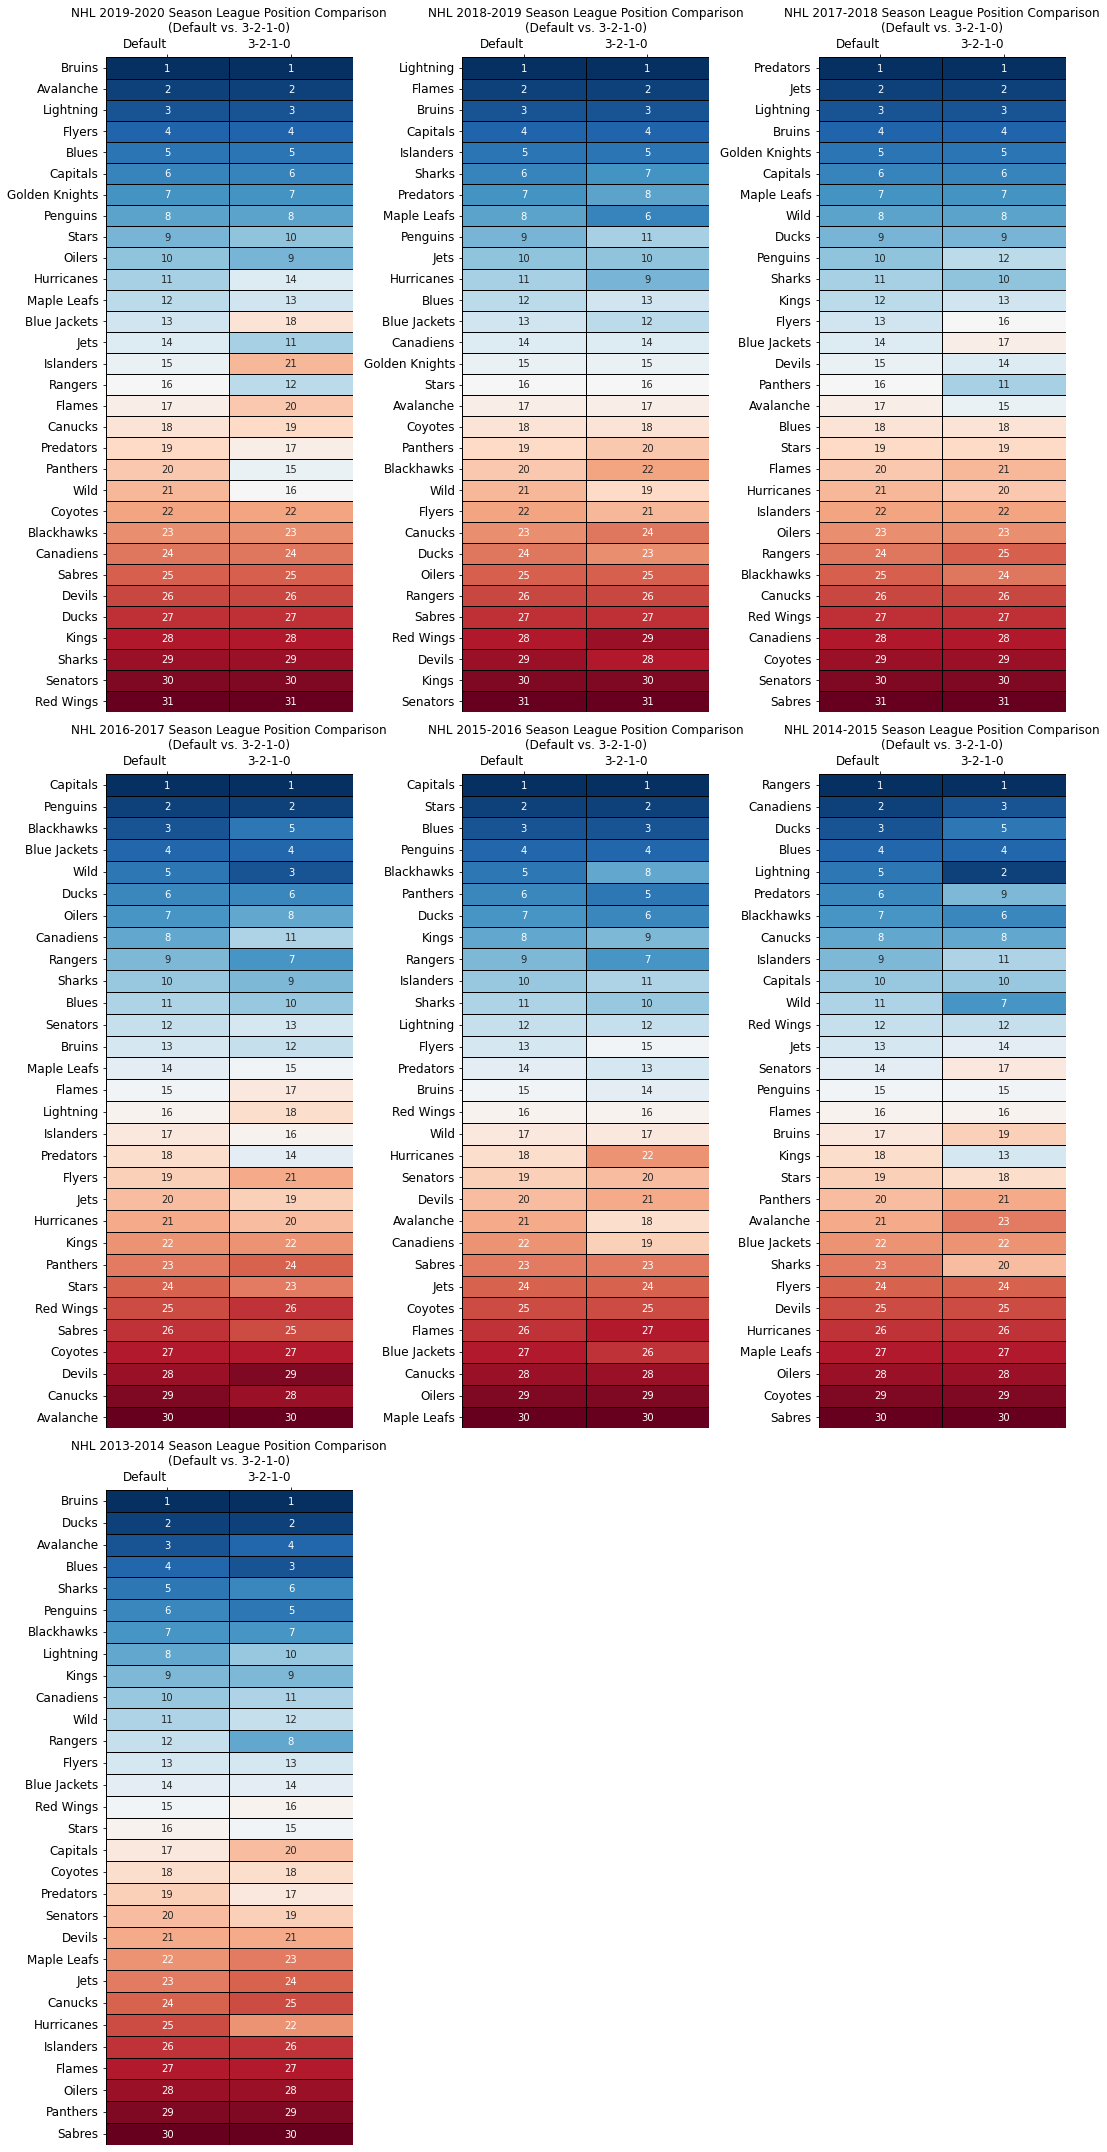

In [10]:
# Plots for how positions change in the league for different systems

# Calculate the number of rows and columns for the grid
num_seasons = len(season_standings)
num_cols = min(3, num_seasons)
num_rows = math.ceil(num_seasons / num_cols)

# Create a figure and axis for subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10 * num_rows))

# Flatten the 2D axs array for easier indexing
axs = axs.flatten()

# sort season_standings by league_positions defaults
season_standings = {season: standings.sort_values(by="league_position_def") for season, standings in season_standings.items()}

# Iterate through season_standings
for i, (season, standings_df) in enumerate(season_standings.items()):
    teams = standings_df["teamName"].tolist()

    # Create a heatmap for each season
    sns.heatmap(standings_df[["league_position_def", "league_position_3210"]], cmap='RdBu_r', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Values'}, linecolor='black', ax=axs[i])

    axs[i].tick_params(axis='both', which='both', labelsize=12)
    axs[i].set_yticks([j + 0.5 for j in range(len(teams))])
    axs[i].set_yticklabels(teams, rotation=0)
    axs[i].xaxis.tick_top()
    axs[i].collections[0].colorbar.remove()

    season_str = str(season)
    axs[i].set_title(f"NHL {season_str[:4]}-{season_str[-4:]} Season League Position Comparison\n(Default vs. 3-2-1-0)")
    axs[i].set_xticklabels(["Default", "3-2-1-0"], rotation=0, ha="right")

# Remove empty subplots if needed
for j in range(num_seasons, num_rows * num_cols):
    fig.delaxes(axs[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [11]:
# Divisional ranks
def assign_ranks(group, def_3210):
    if def_3210 == "def":
        group = group.sort_values(by='points_def', ascending=False)
        group['division_rank_def'] = range(1, len(group) + 1)

    elif def_3210 == "3210":
        group = group.sort_values(by='points_3210', ascending=False)
        group['division_rank_3210'] = range(1, len(group) + 1)

    return group

# calculate in division places for each season for all divisions
for season, standings_df in season_standings.items():

    # Apply the function to each group within the DataFrame for both default and 3-2-1-0 system
    standings_df = standings_df.groupby('division', group_keys=False).apply(assign_ranks, "def")
    standings_df = standings_df.groupby('division', group_keys=False).apply(assign_ranks, "3210")

    # new column 'div_rank' combining division abbreviation and rank
    # standings_df['div_rank_def'] = standings_df['division'] + standings_df['division_rank_def'].astype(str)
    # standings_df['div_rank_3210'] = standings_df['division'] + standings_df['division_rank_3210'].astype(str)
    season_standings[season] = standings_df

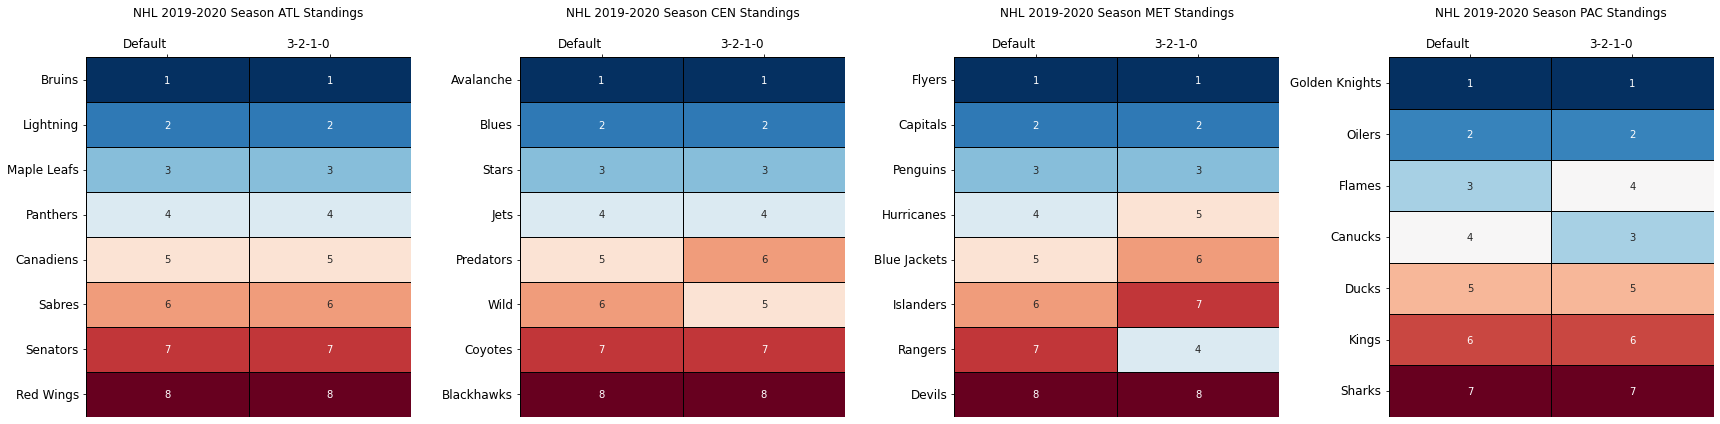

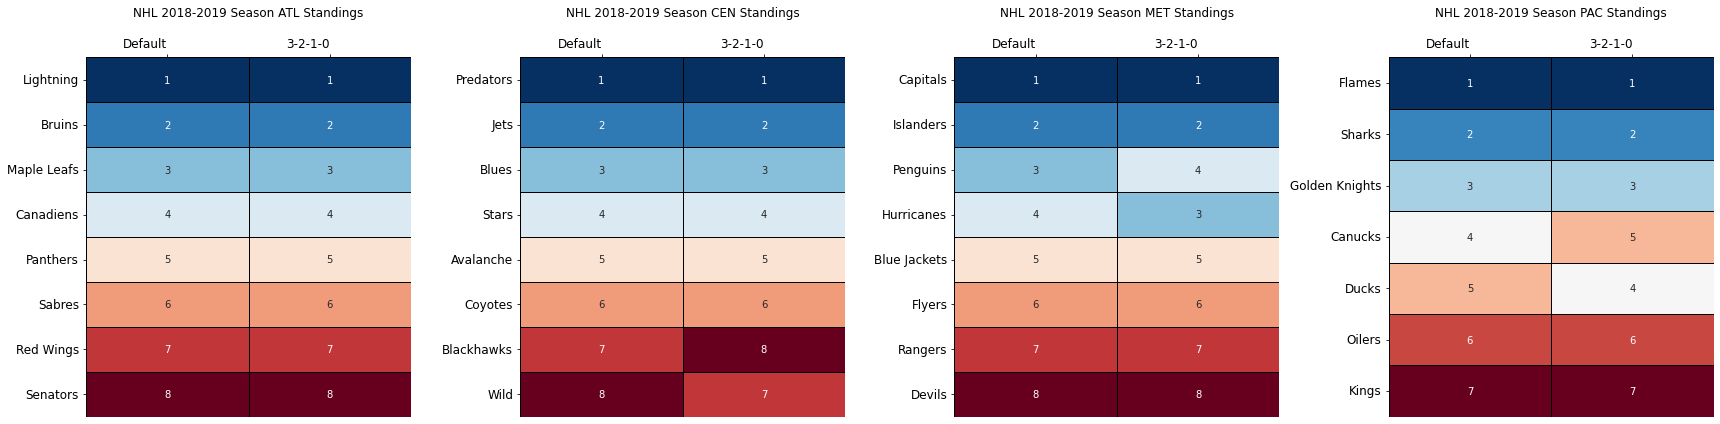

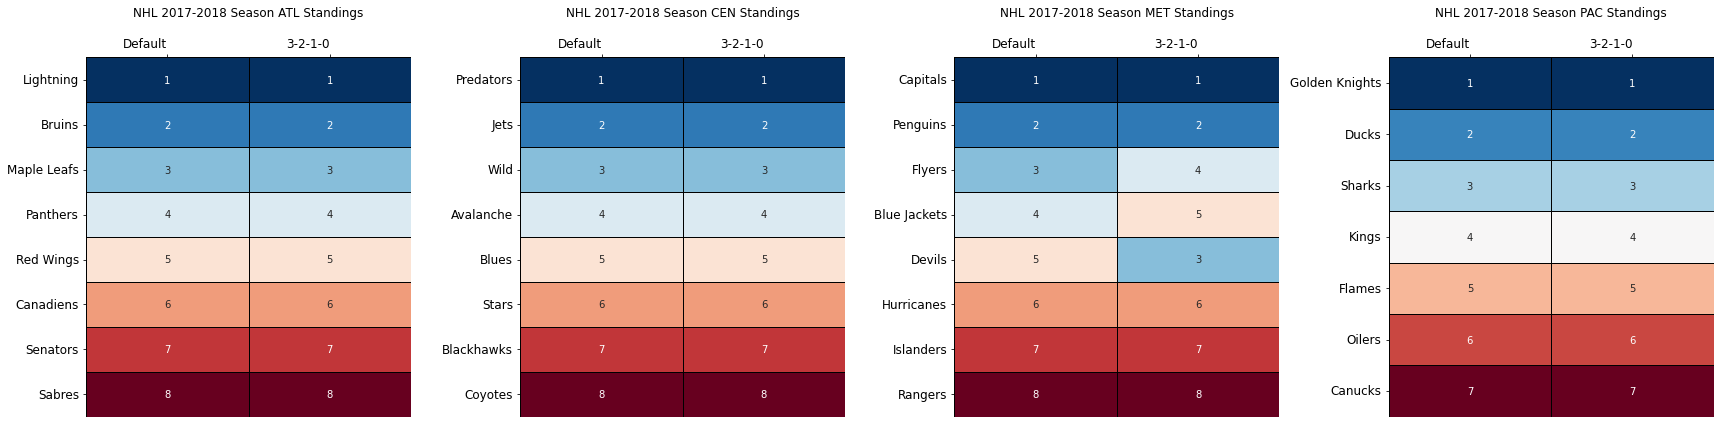

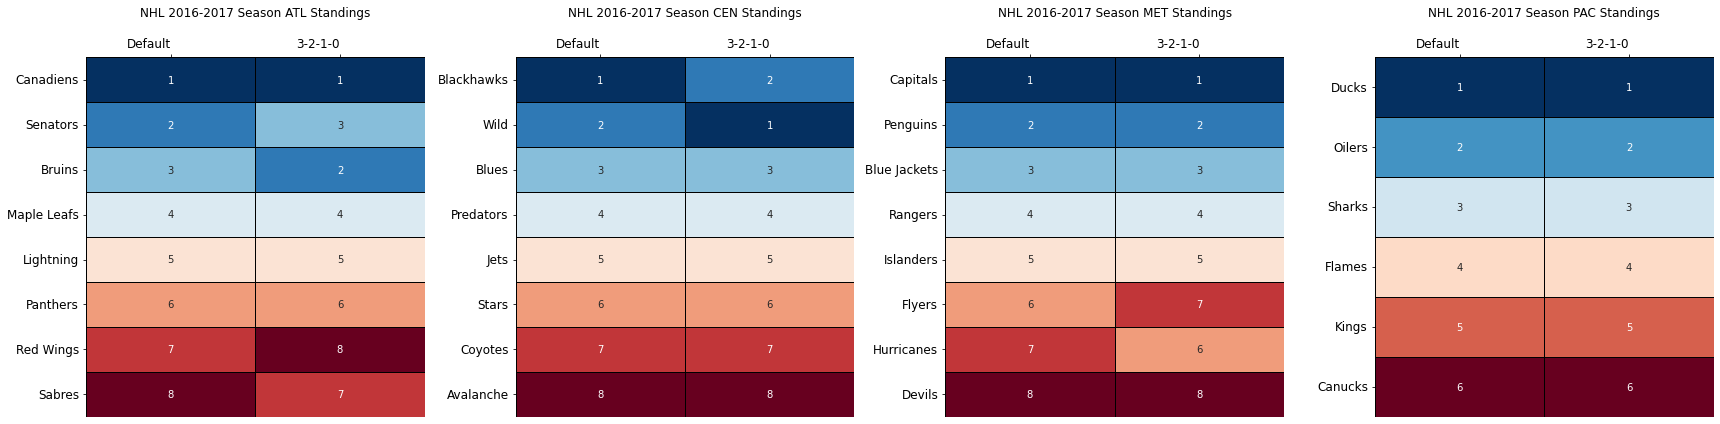

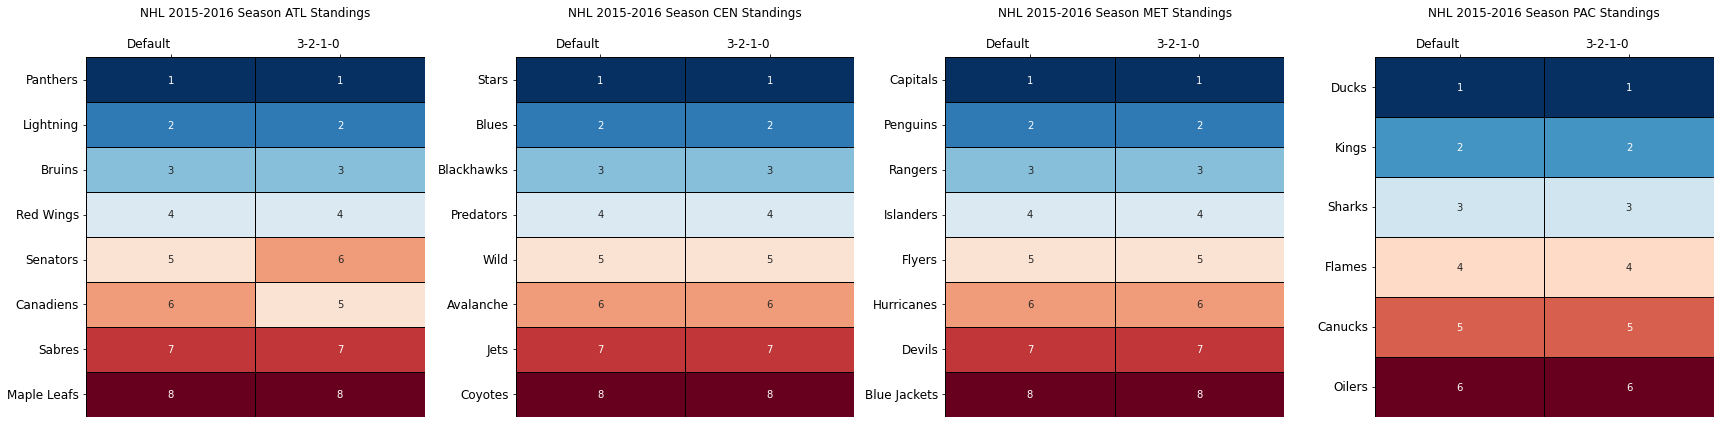

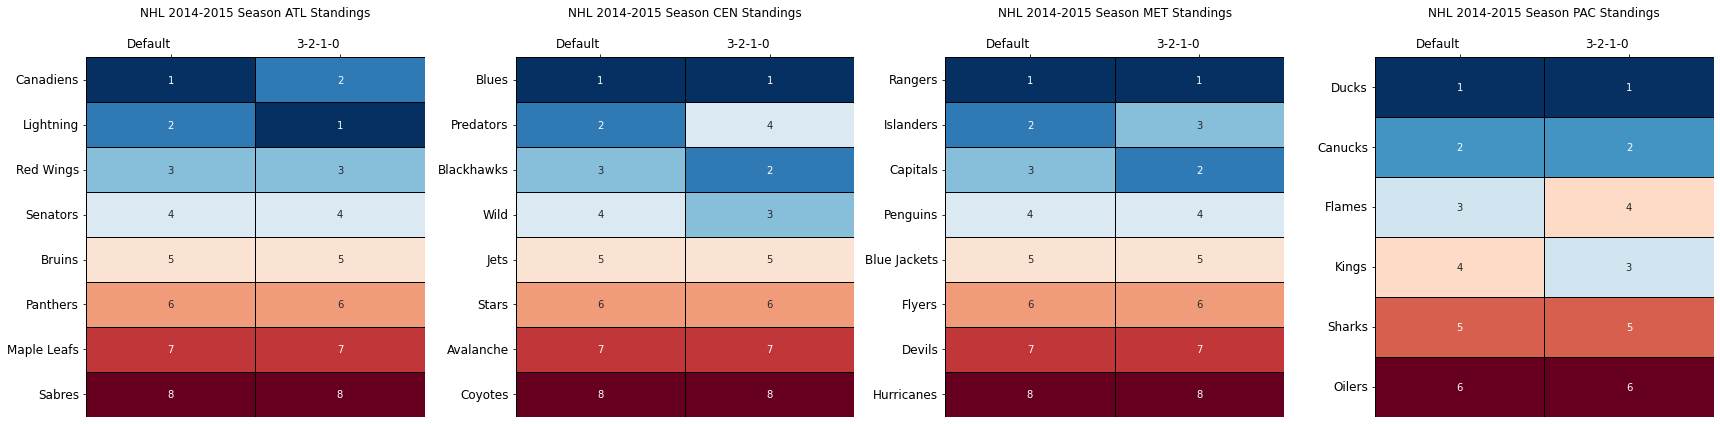

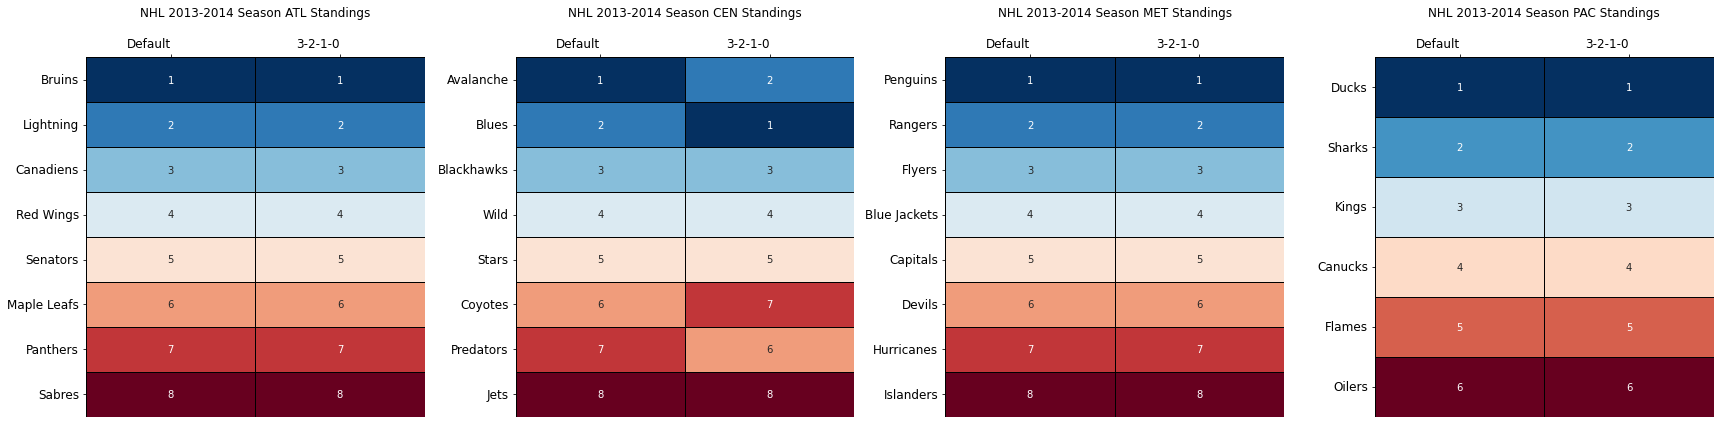

In [12]:
# Plotting all divisional place changes for all the seasons and plotting their trajectories across the 2 systems
for season, standings_df in season_standings.items():
    divisions = standings_df['division'].unique()

    season_str = str(season)
    # Create subplots based on the number of divisions, arranged side by side
    fig, axes = plt.subplots(ncols=len(divisions), figsize=(6 * len(divisions), 6))

    # Iterate over each division
    for i, division in enumerate(divisions):
        teams_df = standings_df[standings_df['division'] == division]
        teams_df = teams_df.sort_values(by='division_rank_def')
        teams = teams_df['teamName'].tolist()

        # Create a heatmap for each division
        ax = sns.heatmap(
            teams_df[["division_rank_def", "division_rank_3210"]],
            cmap='RdBu_r', annot=True, fmt=".0f", linewidths=.5,
            cbar_kws={'label': 'Values'}, linecolor='black', ax=axes[i]
        )

        ax.tick_params(axis='both', which='both', labelsize=12)
        ax.set_yticks([i + 0.5 for i in range(len(teams))])
        ax.set_yticklabels(teams, rotation=0)
        ax.xaxis.tick_top()
        ax.collections[0].colorbar.remove()

        # Set titles and x-axis labels
        ax.set_title(f"NHL {season_str[:4]}-{season_str[-4:]} Season {division} Standings\n")
        ax.set_xticklabels(["Default", "3-2-1-0"], rotation=0, ha="right")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


In [13]:
for season, standings_df in season_standings.items():
    standings_df.to_csv(f"standings_dfs/{season}_standings.csv", index=False)